In [1]:
import pandas as pd
import numpy as np
import py_vollib.black_scholes
import py_vollib_vectorized

In [132]:
def ComputeVol(sigma,slope,strike,spot, texp):
    # sigma is the ATM volatility of the underlying
    # slope is the log normal slope
    # strike is the strike price
    # spot is the spot price
    # texp is the time to expiration in years

    # Compute the log normal volatility
    kvol = sigma + slope * np.log(np.array(strike)/np.array(spot))/np.sqrt(np.array(texp))*10
    return kvol


k=90
s=100
t=.25
sigma=0.2
slope=-0.02
kvol=ComputeVol(sigma,slope,k,s,t)
kvol



0.24214420626313055

In [37]:
def DetermineOptionWeights(cp,spot,sigma,slope,strike, texp,r,div):
    # cp is the call or put
    # spot is the spot price
    # k is the number of strikes
    # sigma is the ATM volatility of the underlying
    # slope is the log normal slope
    # strike is the strike price
    # texp is the time to expiration in years

    # Compute the log normal volatility
    kvol = ComputeVol(sigma,slope,strike,spot, texp)

    # Compute the option prices
    price=py_vollib_vectorized.models.vectorized_black_scholes_merton(cp,spot,strike,texp,r,kvol,div,return_as='array')
    option_greeks = py_vollib_vectorized.get_all_greeks(cp, spot, strike, texp, r, kvol,div,model='black_scholes_merton', return_as='dict')
    # Compute the weights
    qty=[1,-.5,-.5,1]
    # set the outside qty's to be half of the atm vega
    qty[0]=option_greeks["vega"][1]/2/option_greeks["vega"][0]
    qty[3]=option_greeks["vega"][1]/2/option_greeks["vega"][3]
    # adjust the weights of the atm options to be delta neutral#
    # sum_delta = option_greeks['delta']@np.array(qty)
    sum_delta = option_greeks['delta']@np.array(qty)
    qty[1]=qty[1]+sum_delta
    qty[2]=qty[2]-sum_delta

    return (qty,price,option_greeks)

strike=[92,100,100,108]
spot=100
texp=.25
sigma=0.2
slope=-0.02
div=0
r=0
cp=['p']*2+['c']*2
qty,price,option_greeks=DetermineOptionWeights(cp,spot,sigma,slope,strike, texp,r,div)
#vega would need to be scaled down by 100 to use it


In [3]:
strikes=[.92,1,1,1.08]
maturities=[.25]*4
cp=['p']*2+['c']*2


['p', 'p', 'c', 'c']

read the spx index data

In [133]:
df_spx=pd.read_csv('SPX.csv')  
df_spx['date']=pd.to_datetime(df_spx['date'])
df_spx.index=df_spx['date']
df_spx=df_spx.sort_index()

In [134]:
vol_field="SPX - iv90"
slope_field="SPX - slope90"
spx_price_field="SPX - stockpx"
for cur_date, row in df_spx.iterrows():
    #(vol,slope,spot)=(row[vol_field],row[slope_field],row[spx_price_field])
    print(row[vol_field])
    #print("vol_field={}, slope_field={}, spot={}".format(vol,slope,spot))

19.63
19.04
18.43
18.31
17.52
17.71
18.1
17.65
16.69
17.52
17.11
17.29
19.6
21.36
20.88
21.71
20.29
21.14
21.61
20.09
19.6
19.82
22.47
22.63
23.0
22.34
22.63
21.41
20.94
20.42
20.03
18.62
18.94
17.86
19.19
18.83
18.4
18.38
17.59
17.85
17.27
17.51
16.5
16.71
16.78
17.04
17.25
17.19
17.27
16.78
16.68
16.29
16.53
16.82
16.18
17.24
16.92
16.38
16.98
16.64
16.57
16.82
16.07
15.77
15.71
15.53
15.39
15.56
15.52
15.47
15.18
16.49
16.63
15.03
15.51
15.99
16.07
16.79
19.32
17.87
16.32
19.16
18.22
20.16
21.55
25.98
30.01
23.31
23.14
21.47
22.65
25.01
25.03
26.48
27.49
32.55
30.2
29.87
28.18
28.51
23.91
26.11
27.79
24.47
23.95
27.8
29.02
27.49
27.51
25.28
24.7
25.06
22.3
22.73
21.89
21.88
22.23
23.24
22.81
25.5
24.48
25.08
28.2
28.58
28.96
28.1
26.88
24.58
23.61
23.61
23.61
23.58
24.3
24.55
25.25
23.95
22.58
24.13
23.03
21.93
20.9
21.62
22.25
22.48
21.71
20.76
21.28
20.5
20.84
21.37
21.05
21.41
24.24
24.18
24.98
25.08
24.01
23.71
24.9
25.22
24.29
25.38
25.16
25.62
24.23
25.49
25.14
23.16
22.51
21.

In [135]:
shift_days=1
vol_field="SPX - iv90"
slope_field="SPX - slope90"
vol_term=90
short_term=89
vol_field_short="SPX - iv60"
slope_field_short="SPX - slope60"
spx_price_field="SPX - stockpx"
df_back=df_spx[[spx_price_field,vol_field,slope_field,vol_field_short,slope_field_short]].copy()
for col in df_back.columns:
    df_back[col+'_lag']=df_back[col].shift(1)
    #print(col)

df_back["SPX - vol interp_lag"]=df_back["SPX - iv90_lag"]
df_back["SPX - slope interp_lag"]=df_back["SPX - slope90_lag"]

#df_back["SPX - iv89"]=np.interp(89, [60,90], [df_back["SPX - iv60_lag"],df_back["SPX - iv90_lag"]])
#df_back=df_back.dropna().ffill()
#df_back["SPX - iv60_lag"]=df_back["SPX - iv60"].shift(1)
df_back.replace(0, np.nan, inplace=True)
df_back=df_back.fillna(method='ffill')
df_back


,SPX - stockpx,SPX - iv90,SPX - slope90,SPX - iv60,SPX - slope60,SPX - stockpx_lag,SPX - iv90_lag,SPX - slope90_lag,SPX - iv60_lag,SPX - slope60_lag,SPX - vol interp_lag,SPX - slope interp_lag
date,,,,,,,,,,,,
2010-01-04,1132.99,19.63,-2.445982,17.73,-2.304929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,19.04,-2.392252,17.18,-2.241417,1132.99,19.63,-2.445982,17.73,-2.304929,19.63,-2.445982
2010-01-06,1137.14,18.43,-2.334793,17.01,-2.182068,1136.52,19.04,-2.392252,17.18,-2.241417,19.04,-2.392252
2010-01-07,1141.69,18.31,-2.274502,16.79,-2.112218,1137.14,18.43,-2.334793,17.01,-2.182068,18.43,-2.334793
2010-01-08,1144.98,17.52,-2.159981,16.11,-1.981440,1141.69,18.31,-2.274502,16.79,-2.112218,18.31,-2.274502
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-15,4147.60,16.43,-2.566487,16.43,-2.315465,4136.13,16.61,-2.557923,16.70,-2.311822,16.61,-2.557923
2023-02-16,4090.41,17.17,-2.736032,18.40,-2.544699,4147.60,16.43,-2.566487,16.43,-2.315465,16.43,-2.566487
2023-02-17,4079.09,17.37,-2.702596,17.41,-2.474287,4090.41,17.17,-2.736032,18.40,-2.544699,17.17,-2.736032


In [148]:
r=0
div=0
cp=['p']*2+['c']*2
strike=np.array([.90,1,1,1.1])
spot=100
texp=90/365
sigma=0.2   
slope=-0.02
option_pnl=[]
for ind, row in df_back.iterrows():
    (vol,slope,spot)=(row[vol_field+"_lag"],row[slope_field+"_lag"],row[spx_price_field+"_lag"])
    #print("vol_field={}, slope_field={}, spot={}, spot*strike={}".format(vol,slope,spot,strike*spot))
    qty,price,option_greeks=DetermineOptionWeights(cp,spot,vol/100,slope/100,strike*spot, texp,r,div)
    #price the same options tomorrow
    (vol_end,slope_end,spot_end)=(row[vol_field],row[slope_field],row[spx_price_field]) 
    qty_end,price_end,option_greeks_end=DetermineOptionWeights(cp,spot_end,vol_end/100,slope_end/100,strike*spot, texp-shift_days/252,r,div) 
    pnl=price_end-price
    scaled_pnl=np.array(pnl)@np.array(qty)/spot
    option_pnl.append(scaled_pnl)
    #print("pnl={},prices={}, end_prices={}".format(scaled_pnl, price, price_end))
df_back["option_pnl"]=np.minimum(option_pnl,.003)
df_back["option_pnl"][df_back["option_pnl"]>.003]

Series([], Name: option_pnl, dtype: float64)

import matplotlib
import matplotlib.pyplot as plt

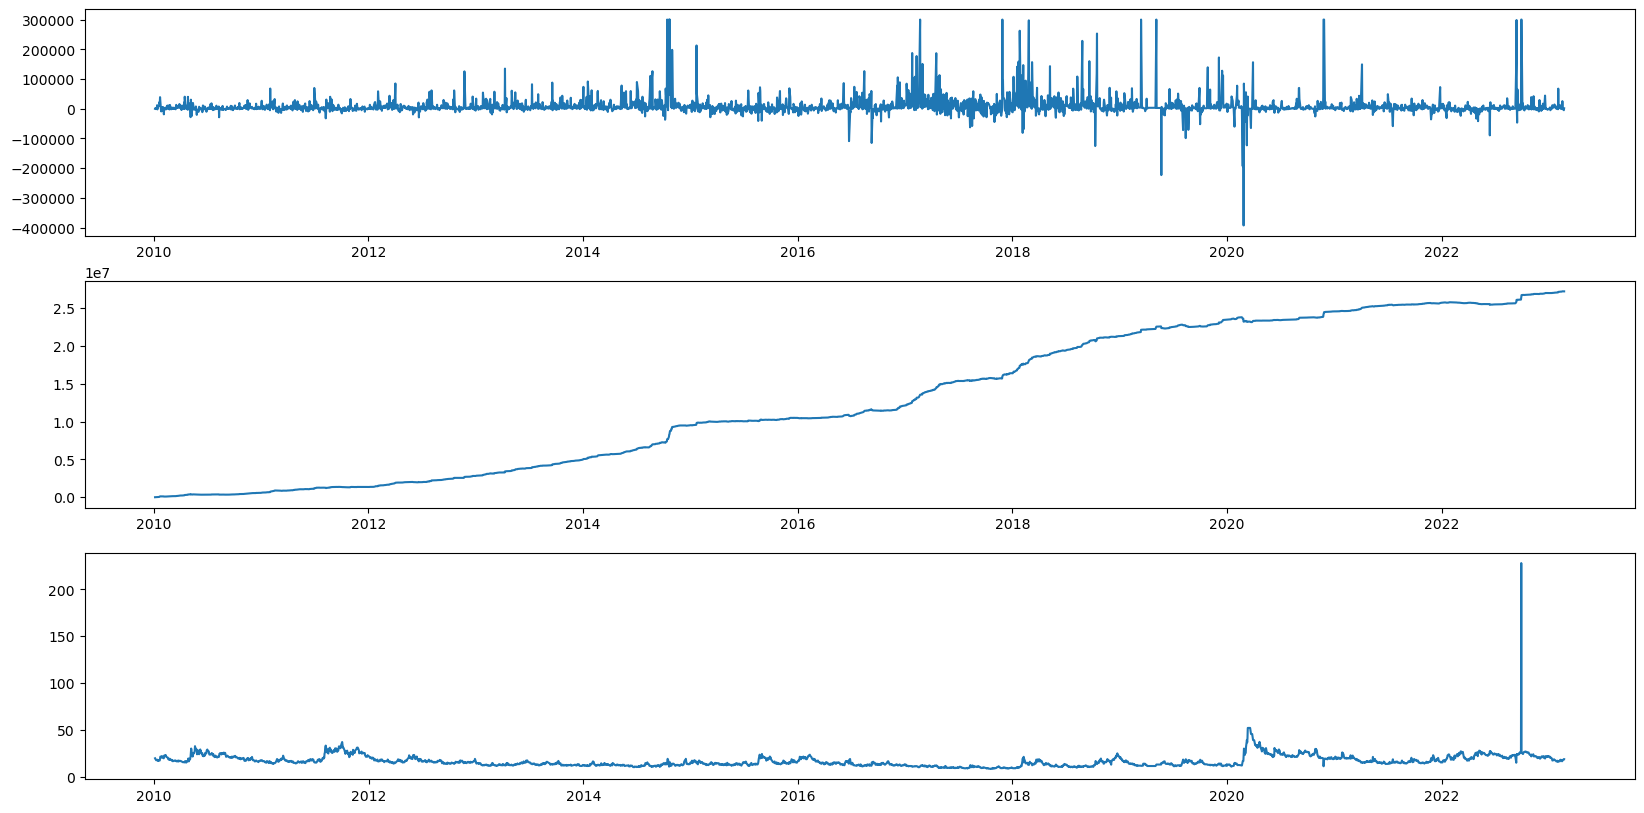

In [149]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax= plt.subplots(3,1,figsize=(20, 10))
ax[0].plot(df_back.index,df_back["option_pnl"]*100e6)
ax[1].plot(df_back.index,df_back["option_pnl"].cumsum()*100e6)
ax[2].plot(df_back.index,df_back["SPX - iv90"])

In [84]:
df_back["SPX - iv60_lag"].to_numpy()
qty,price,option_greeks=DetermineOptionWeights(cp,spot,sigma,slope,strike, texp,r,div)

array([  nan, 17.73, 17.18, ..., 18.4 , 17.41, 19.03])